<a href="https://colab.research.google.com/github/riya-chougule/Image_segmentation_for_self_driving_cars_using_deep_learning_techniques/blob/main/prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import PIL
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path_data = Path('/content/gdrive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg')
path_lbl = path_data/'labels'
path_img = path_data/'images'

In [4]:
fnames = get_image_files(path_img/'train', recurse = True)
fnames[:3]

[PosixPath('/content/gdrive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/train/0004a4c0-d4dff0ad.jpg'),
 PosixPath('/content/gdrive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/train/00054602-3bf57337.jpg'),
 PosixPath('/content/gdrive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/train/00067cfb-e535423e.jpg')]

In [5]:
lbl_names = get_image_files(path_lbl, recurse = True)
lbl_names[:3]

[PosixPath('/content/gdrive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/labels/train/0004a4c0-d4dff0ad_train_id.png'),
 PosixPath('/content/gdrive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/labels/train/00054602-3bf57337_train_id.png'),
 PosixPath('/content/gdrive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/labels/train/00067cfb-e535423e_train_id.png')]

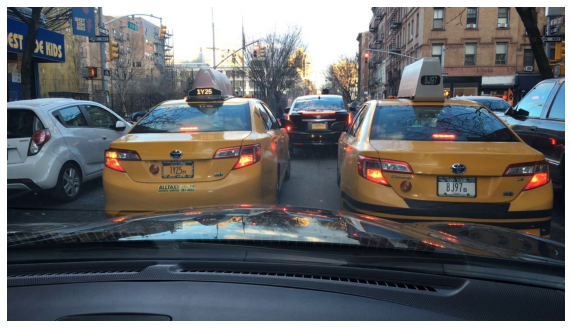

In [6]:

img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(10,10))

In [7]:
get_y_fn = lambda x: path_lbl/x.parts[-2]/f'{x.stem}_train_id.png'

img_f, get_y_fn(img_f)

(PosixPath('/content/gdrive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/train/0004a4c0-d4dff0ad.jpg'),
 PosixPath('/content/gdrive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/labels/train/0004a4c0-d4dff0ad_train_id.png'))

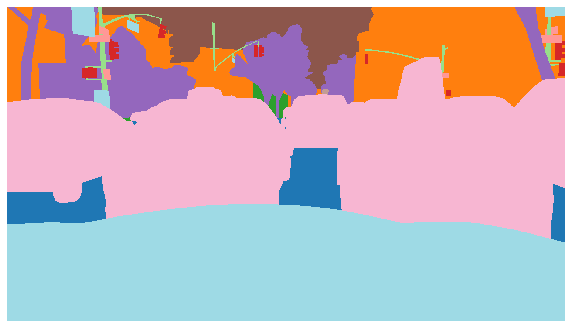

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10,10), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 720, 1280]), tensor([[[ 2,  2,  8,  ..., 19, 19, 19],
          [ 2,  2,  2,  ..., 19, 19, 19],
          [ 2,  2,  2,  ..., 19, 19, 19],
          ...,
          [19, 19, 19,  ..., 19, 19, 19],
          [19, 19, 19,  ..., 19, 19, 19],
          [19, 19, 19,  ..., 19, 19, 19]]]))

In [10]:
size = (180, 320)
bs = 16

In [11]:
segmentation_classes = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
    'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'void'
]
void_code = 19 

In [12]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_folder(train='train', valid='val')
       .label_from_func(get_y_fn, classes = segmentation_classes))

In [13]:
src.train.y.loss_func

FlattenedLoss of CrossEntropyLoss()

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

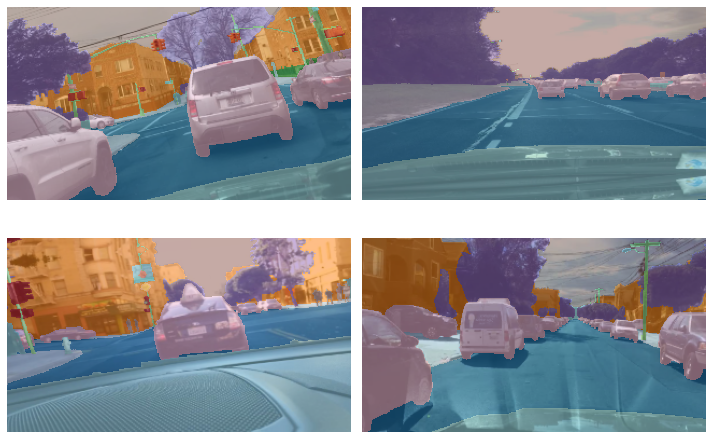

In [15]:
data.show_batch(2, figsize=(10,7))

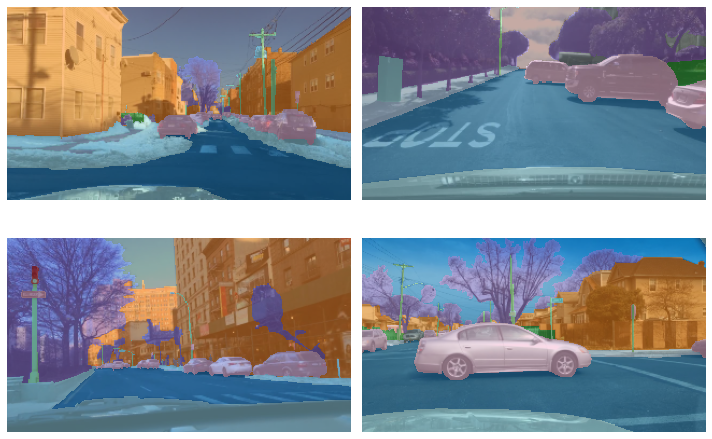

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [17]:
def acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc

In [21]:
wd=1e-3

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch,train_loss,valid_loss,acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


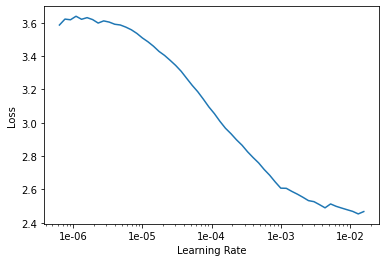

In [23]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lr=3e-3

In [25]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,acc,time
0,0.875500,0.753181,0.820825,07:07
1,0.731036,0.578710,0.847337,07:02
2,0.598920,0.511059,0.858672,07:04


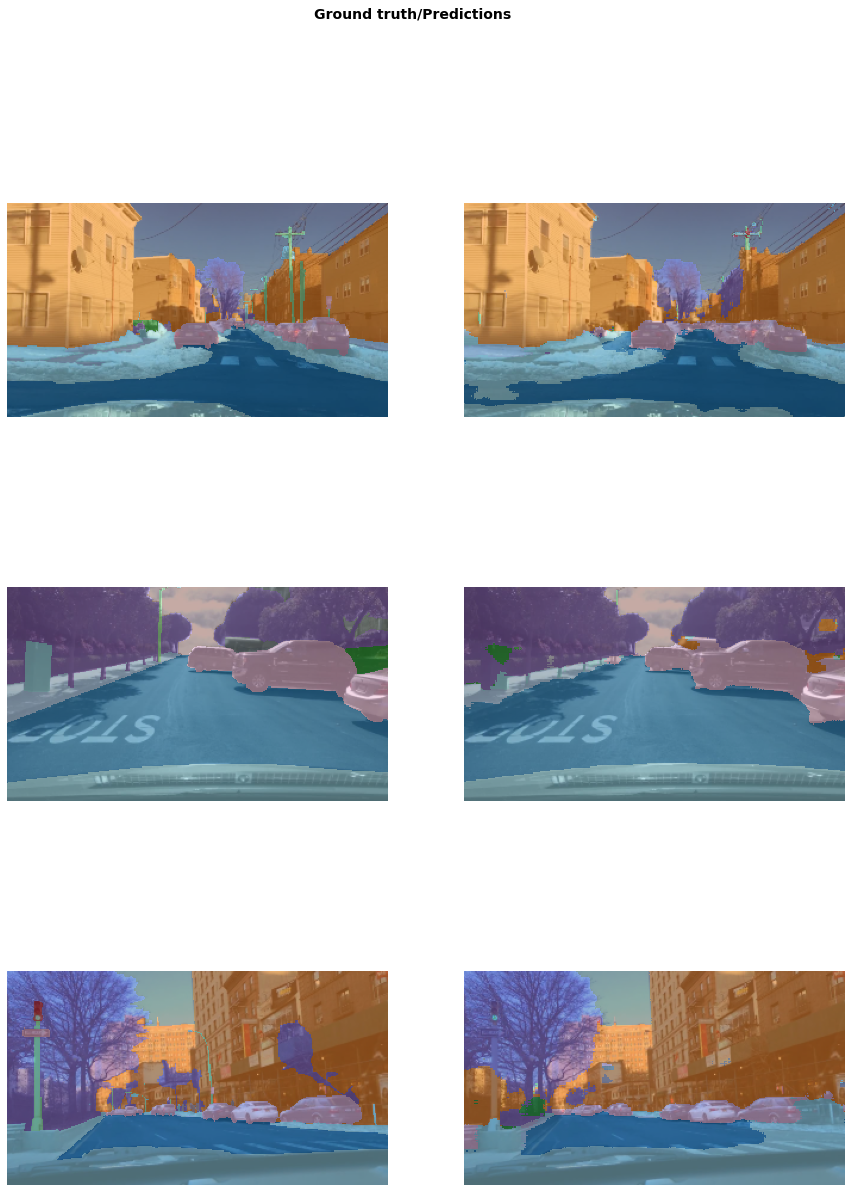

In [28]:
learn.show_results(rows=3, figsize=(15,20))

In [29]:
learn.unfreeze()

In [30]:
lrs = slice(lr/400,lr/4)

In [31]:
learn.fit_one_cycle(3, lrs, pct_start=0.5)

epoch,train_loss,valid_loss,acc,time
0,0.622149,0.517400,0.857199,07:03
1,1.145891,0.962157,0.692159,07:07
2,0.749078,0.669483,0.813352,07:02


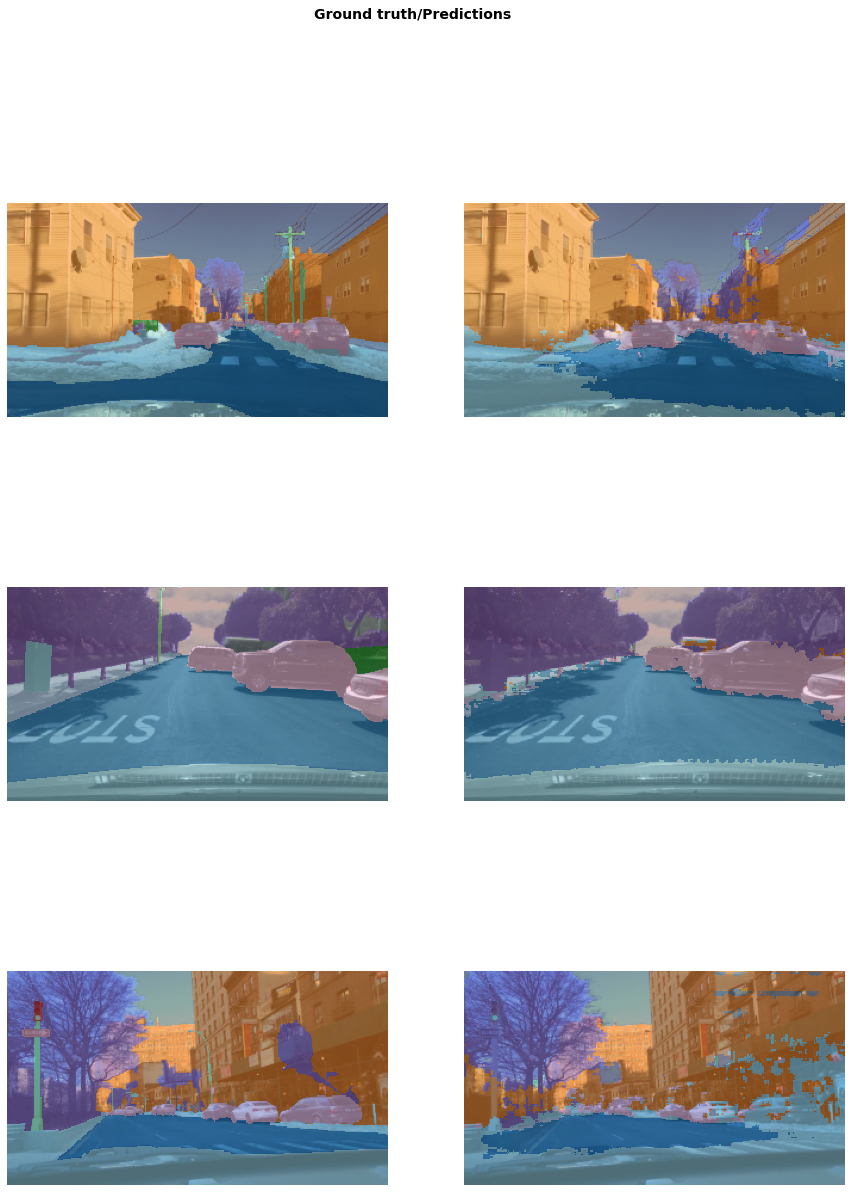

In [33]:
learn.show_results(rows=3, figsize=(15,20))

In [1]:
pwd

'/content'